# Integrating neuron (Type 1)

## without adaptaion
$$
\begin{array}{rll}
L_1(v,v_3,r_0,r_1,0)       &\dot{v}&=P_3(v,v_0,v_1,v_2)L_1(v,v_0,a_0,a_1,0)+I-w^2\\
S_2(v,v_6,,v_7,s_0,s_1,s_2)&\dot{w}&=L_2(v,v_4,0,v_5,1,0,0)-w
\end{array}
$$

### with saddale-node depolarization block

In [5]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *
from scipy.integrate import odeint
import sympy 
from pls import *
v0,v1,v2 = -65.,-45., 55.
a0,a1    = 3.5e-6,-1e-4 #a2 = 0.
vmin,vmax= -55.45176241886681, 18.78509575220014
I0       = -a0*(vmin-v0)*(vmin-v1)*(v2-vmin)
I1       = 1.-a0*(vmax-v0)*(vmax-v1)*(v2-vmax)
#--- \tau_v
v3       = -35.
r0,r1    = 0.04, -0.004 #r2 = 0.
#--- n_\infty
v4,v5    = -40.,-5.
#--- \tau_n
v6,v7    = vmin,vmax
s0,s1,s2 = 5.,7.6,1.8
print(I0,I1)


0.038579219773071036 0.32260596541211417


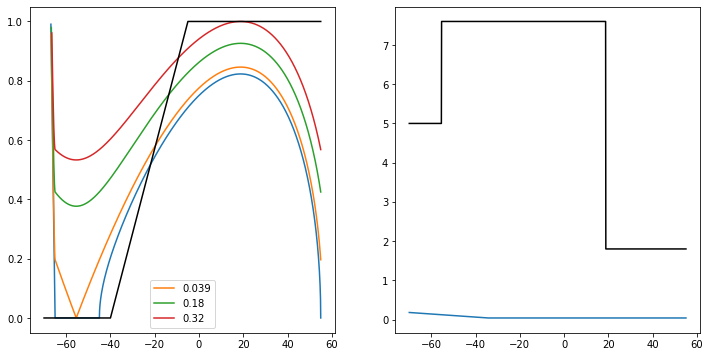

In [6]:
def safesqrt(x,y,limit=None):
    if limit is None:
        return column_stack((x[where(y>=0.)],sqrt(y[where(y>=0.)])))
    else:
        z = safesqrt(x,y)
        return z[where(z[:,1]<limit)]
vm      = linspace(-70,55,1251)
v0c   = safesqrt(vm, vectorize(P3)(vm,v0,v1,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+0. ,1)
v0cI0 = safesqrt(vm, vectorize(P3)(vm,v0,v1,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+I0 ,1)
v0cI05= safesqrt(vm, vectorize(P3)(vm,v0,v1,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+(I0+I1)/2 ,1)
v0cI1 = safesqrt(vm, vectorize(P3)(vm,v0,v1,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+I1 ,1)

f1=figure(1,figsize=(12,6))
subplot(121)
plot(v0c[:,0],v0c[:,1])
plot(v0cI0[:,0], v0cI0[:,1],label='{:0.2g}'.format(I0))
plot(v0cI05[:,0],v0cI05[:,1],label='{:0.2g}'.format((I0+I1)/2))
plot(v0cI1[:,0], v0cI1[:,1],label='{:0.2g}'.format(I1))
plot(vm,vectorize(L2)(vm,v4,0.,v5,1.,0.,0.),"k-")
legend(loc=0)

subplot(122)
plot(vm,vectorize(L1)(vm,v3,r0,r1,0.))
plot(vm,vectorize(S2)(vm,v6,v7,s0,s1,s2),"k-")
f1.savefig("pls-t1-nulls-saddlenode-depblk.svg")
f1.savefig("pls-t1-nulls-saddlenode-depblk.png")
show()


In [7]:
symV, symW, symI = sympy.symbols('v w I')

def getroots(I):
    vm = linspace(v0-1.,v2+1.,int(v2-v0)*100+102)
    vnull = vectorize(P3)(vm,v0,v1,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+I
    wnull = vectorize(L2)(vm,v4,0.,v5,1.,0.,0.)
    vnull = sqrt(vnull)
    idx = where((vnull-wnull)**2<1e-3)[0]
    if   len(idx) > 2:
        idx = [idx[0]]+[l2 for l1,l2 in zip(idx[:-1],idx[1:]) if l1+1 != l2]
    return vm[idx],vectorize(L2)(vm[idx],v4,0.,v5,1.,0.,0.)

def getJacobian(v,w,I):
    vrhs = (symP3(symV,v,v0,v1,v2)*symL1(symV,v,v0,a0,a1,0.)+symI-symW**2)/symL1(symV,v,v3,r0,r1,0.)
    wrhs = (symL2(symV,v,v4,0.,v5,1.,0.,0.)-w)/symS2(symV,v,v6,v7,s0,s1,s2)
    dvdv, dvdw = vrhs.diff(symV),vrhs.diff(symW)
    dwdv, dwdw = wrhs.diff(symV),wrhs.diff(symW)
    return array([
        [dvdv.subs(symV,v).subs(symW,w).subs(symI,I),dvdw.subs(symV,v).subs(symW,w).subs(symI,I)],
        [dwdv.subs(symV,v).subs(symW,w).subs(symI,I),dwdw.subs(symV,v).subs(symW,w).subs(symI,I)]
    ])

def getStability(I,verb=False):
    vx,wx = getroots(I)
    ret = []
    for v,w in zip(vx,wx):
        #print("vwi",v,w,I)
        m = getJacobian(v,w,I)
        #print("m",m.tolist())
        if verb:
            print("=== FIX POINT ===")
            print(" > V*={:0.2f} W*={:0.2f}".format(v,w))
            #print(" > tau={:0.2f} det={:0.2f}".format(m[0,0]+m[1,1], m[0,0]*m[1,1]-m[1,0]*m[0,1]))
        ev, eV = linalg.eig(m.astype(complex))
        if verb:
            print(ev)
            print(eV)
        ret.append( (v,w,ev,eV))
    return ret
print( getStability(0.) )

[(-65.04222791504834, 0.0, array([-0.17959872+0.j,  0.        +0.j]), array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])), (-44.999586811007354, 0.0, array([0.08750651+0.j, 0.        +0.j]), array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])), (-24.05966449053797, 0.45543815741320093, array([0.17652953+0.23333667j, 0.17652953-0.23333667j]), array([[0.99991747+0.j        , 0.99991747+0.j        ],
       [0.00775143-0.01024584j, 0.00775143+0.01024584j]]))]


<ipython-input-7-14e363a02e63>:7: RuntimeWarning: invalid value encountered in sqrt
  vnull = sqrt(vnull)


In [8]:
def getCurr(t):
    if          t <  500: return I0
    elif 500 <= t < 9000: return I0*1.01
    else                : return I1*(0.9+0.2*(t-9000)/1000)
def t1rhs(Y,t):
    v,w = Y
    return[
        (P3(v,v0,v1,v2)*L1(v,v0,a0,a1,0.)+getCurr(t)-w**2)/L1(v,v3,r0,r1,0.),
        (L2(v,v4,0.,v5,1.,0.,0.)-w)/S2(v,v6,v7,s0,s1,s2)
    ]
I = I1/(10000-500)
at = arange(0,10000,0.01)
res = odeint(t1rhs,[vmin,0],at)

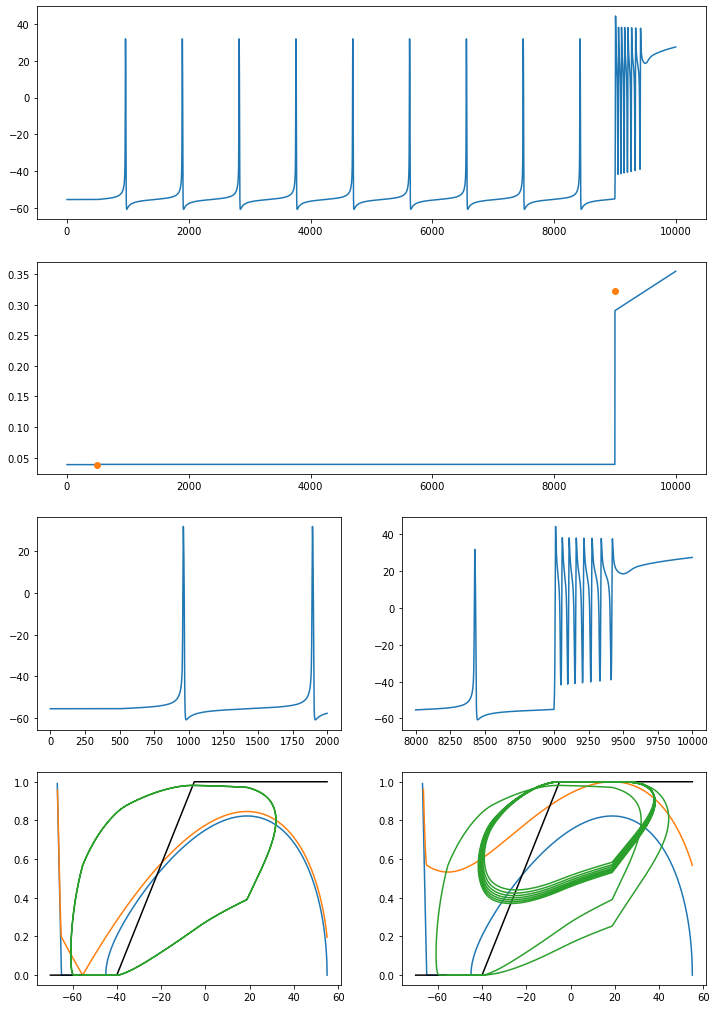

In [9]:
f2 = figure(2, figsize=(12,18))
subplot2grid((4,2),(0,0),colspan=2)
plot(at,res[:,0])
subplot2grid((4,2),(1,0),colspan=2)
plot(at,vectorize(getCurr)(at))
plot([500.,9000.],[I0,I1],'o')

subplot2grid((4,2),(2,0))
plot(at[:200000],res[:200000,0])
subplot2grid((4,2),(2,1))
plot(at[-200000:],res[-200000:,0])
subplot2grid((4,2),(3,0))
plot(v0c[:,0],v0c[:,1])
plot(v0cI0[:,0],v0cI0[:,1])
plot(vm,vectorize(L2)(vm,v4,0.,v5,1.,0.,0.),"k-")
plot(res[:200000,0],res[:200000,1])
subplot2grid((4,2),(3,1))
plot(v0c[:,0],v0c[:,1])
plot(v0cI1[:,0],v0cI1[:,1])
plot(vm,vectorize(L2)(vm,v4,0.,v5,1.,0.,0.),"k-")
plot(res[-200000:,0],res[-200000:,1])
f2.savefig("pls-t1-ramp-saddlenode-depblk.svg")
f2.savefig("pls-t1-ramp-saddlenode-depblk.png")
show()

### with andronove-hopf depolarization block

In [10]:
v4,v5    = vmin+2.5,vmax+2.5


In [11]:
I   = I0*0.9
ret = getStability(I)
while len(ret) != 1:
    I += I0*0.05
    ret = getStability(I)


fv,fw,fev,feV = ret[0]

while not (fev[0].real <= 0. and fev[1].real <= 0.):
    Ic = I
    I += I0*0.01
    ret = getStability(I)
    fv,fw,fev,feV = ret[0]

print(Ic,I,fev)
I2=(Ic+I)/2
#I2=I2*(3500-50)/(10000-500)

<ipython-input-7-14e363a02e63>:7: RuntimeWarning: invalid value encountered in sqrt
  vnull = sqrt(vnull)


0.31827856312784014 0.31866435532557086 [-0.00012688+0.60136721j -0.00012688-0.60136721j]


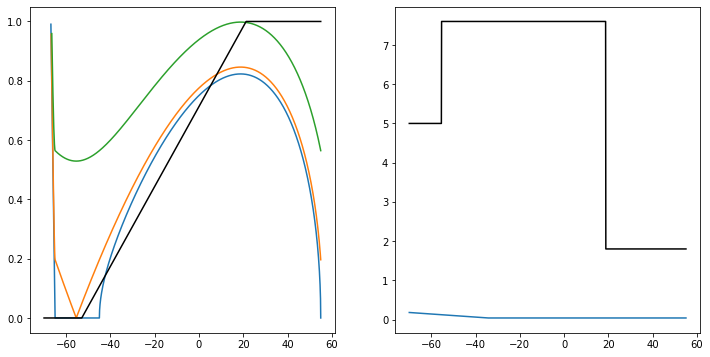

In [12]:
v0c   = safesqrt(vm, vectorize(P3)(vm,v0,v1,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+0. ,1)
v0cI0 = safesqrt(vm, vectorize(P3)(vm,v0,v1,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+I0 ,1)
v0cI1 = safesqrt(vm, vectorize(P3)(vm,v0,v1,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+I2 ,1)

f1=figure(1,figsize=(12,6))
subplot(121)
plot(v0c[:,0],v0c[:,1])
plot(v0cI0[:,0],v0cI0[:,1])
plot(v0cI1[:,0],v0cI1[:,1])
plot(vm,vectorize(L2)(vm,v4,0.,v5,1.,0.,0.),"k-")

subplot(122)
plot(vm,vectorize(L1)(vm,v3,r0,r1,0.))
plot(vm,vectorize(S2)(vm,v6,v7,s0,s1,s2),"k-")
show()

In [13]:
def t1rhs(Y,t):
    v,w = Y
    return[
        (P3(v,v0,v1,v2)*L1(v,v0,a0,a1,0.)+I*(t-50)-w**2)/L1(v,v3,r0,r1,0.),
        (L2(v,v4,0.,v5,1.,0.,0.)-w)/S2(v,v6,v7,s0,s1,s2)
    ]
I = I2/(10000-500)
at = arange(0,10000,0.01)
res = odeint(t1rhs,[v0,0],at)


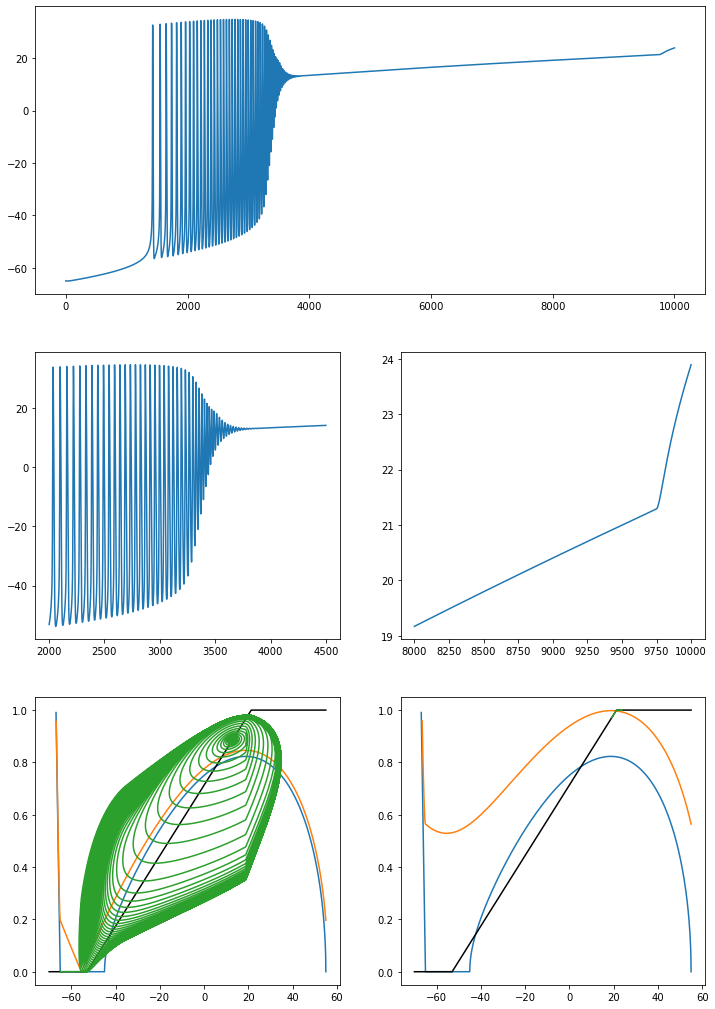

In [14]:
f2 = figure(2, figsize=(12,18))
subplot2grid((3,2),(0,0),colspan=2)
plot(at,res[:,0])
subplot2grid((3,2),(1,0))
plot(at[200000:450000],  res[200000:450000,0])
subplot2grid((3,2),(1,1))
plot(at[-200000:],res[-200000:,0])
subplot2grid((3,2),(2,0))
plot(v0c[:,0],v0c[:,1])
plot(v0cI0[:,0],v0cI0[:,1])
plot(vm,vectorize(L2)(vm,v4,0.,v5,1.,0.,0.),"k-")
plot(res[:400000,0],res[:400000,1])
subplot2grid((3,2),(2,1))
plot(v0c[:,0],v0c[:,1])
plot(v0cI1[:,0],v0cI1[:,1])
plot(vm,vectorize(L2)(vm,v4,0.,v5,1.,0.,0.),"k-")
plot(res[-200000:,0],res[-200000:,1])


show()

## with linear adaptaion
$$
\begin{array}{rll}
L_1(v,v_3,r_0,r_1,0)       &\dot{v}&=P_3(v,v_0,v_1,v_2)L_1(v,v_0,a_0,a_1,0)+I-w^2 - z\\
S_2(v,v_6,,v_7,s_0,s_1,s_2)&\dot{w}&=L_2(v,v_4,0,v_5,1,0,0)-w \\
q_0                         &\dot{z}&=L_2(v,v_8,z_0,v_9,z_1,0,0)-z \\
\end{array}
$$

In [15]:
v4,v5    = -40.,-5.
#--- z_\infty
v8,v9    = -35.,10.
z0,z1    = 0., 2.
#--- \tua_z
q0       = 500

In [16]:
def t1rhs(Y,t):
    v,w,z = Y
    return[
        (P3(v,v0,v1,v2)*L1(v,v0,a0,a1,0.)+I1-w**2-z)/L1(v,v3,r0,r1,0.),
        (L2(v,v4,0.,v5,1.,0.,0.)-w)/S2(v,v6,v7,s0,s1,s2),
        (L2(v,v8,z0,v9,z1,0.,0.)-z)/q0
    ]

at = arange(0,2000,0.01)
res = odeint(t1rhs,[v0,0,0],at)

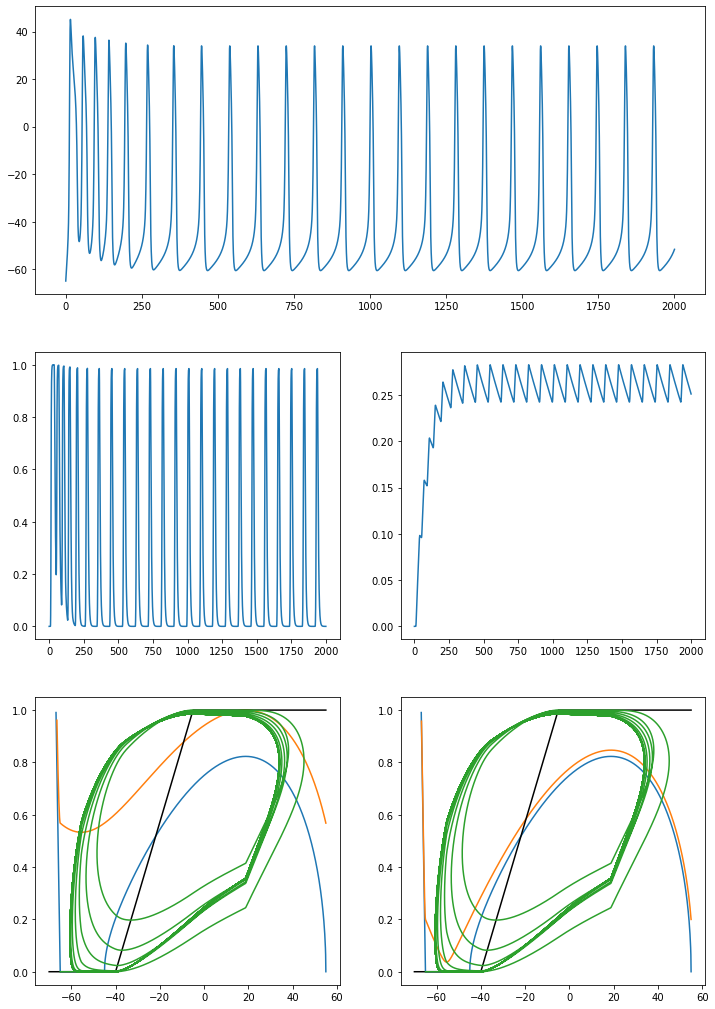

In [17]:
v0c   = safesqrt(vm, vectorize(P3)(vm,v0,v1,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+0. ,1)
v0cI0 = safesqrt(vm, vectorize(P3)(vm,v0,v1,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+I1 ,1)
v0cI1 = safesqrt(vm, vectorize(P3)(vm,v0,v1,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+I1-amax(res[:,2]) ,1)


f2 = figure(2, figsize=(12,18))
subplot2grid((3,2),(0,0),colspan=2)
plot(at,res[:,0])
subplot2grid((3,2),(1,0))
plot(at,res[:,1])
subplot2grid((3,2),(1,1))
plot(at,res[:,2])
subplot2grid((3,2),(2,0))
plot(v0c[:,0],v0c[:,1])
plot(v0cI0[:,0],v0cI0[:,1])
plot(vm,vectorize(L2)(vm,v4,0.,v5,1.,0.,0.),"k-")
plot(res[:200000,0],res[:200000,1])
subplot2grid((3,2),(2,1))
plot(v0c[:,0],v0c[:,1])
plot(v0cI1[:,0],v0cI1[:,1])
plot(vm,vectorize(L2)(vm,v4,0.,v5,1.,0.,0.),"k-")
plot(res[-200000:,0],res[-200000:,1])

show()

## with non-linear adaptaion
$$
\begin{array}{rll}
L_1(v,v_3,r_0,r_1,0)       &\dot{v}&=P_3(v,v_0+z,v1+z,v_2)L_1(v,v_0+z,a_0,a_1,0)+I-w^2\\
S_2(v,v_6,,v_7,s_0,s_1,s_2)&\dot{w}&=L_2(v,v_4,0,v_5,1,0,0)-w \\
q_0                        &\dot{z}&=L_2(v,v_8,v_1,v_9,v_1+\Delta,0,0)-z \\
\end{array}
$$

In [18]:
v4,v5    = -40.,-5.
#--- z_\infty
v8,v9    = -35.,10.
Delta    = 100
z0,z1    = 0,Delta
#--- \tua_z
q0       = 250

In [19]:
def t1rhs(Y,t):
    v,w,z = Y
    return[
        (P3(v,v0+z,v1+z,v2)*L1(v,v0+z,a0,a1,0.)+I1-w**2)/L1(v,v3,r0,r1,0.),
        (L2(v,v4,0.,v5,1.,0.,0.)-w)/S2(v,v6,v7,s0,s1,s2),
        (L2(v,v8,z0,v9,z1,0.,0.)-z)/q0
    ]

at = arange(0,2000,0.01)
res = odeint(t1rhs,[v0,0,0.],at)

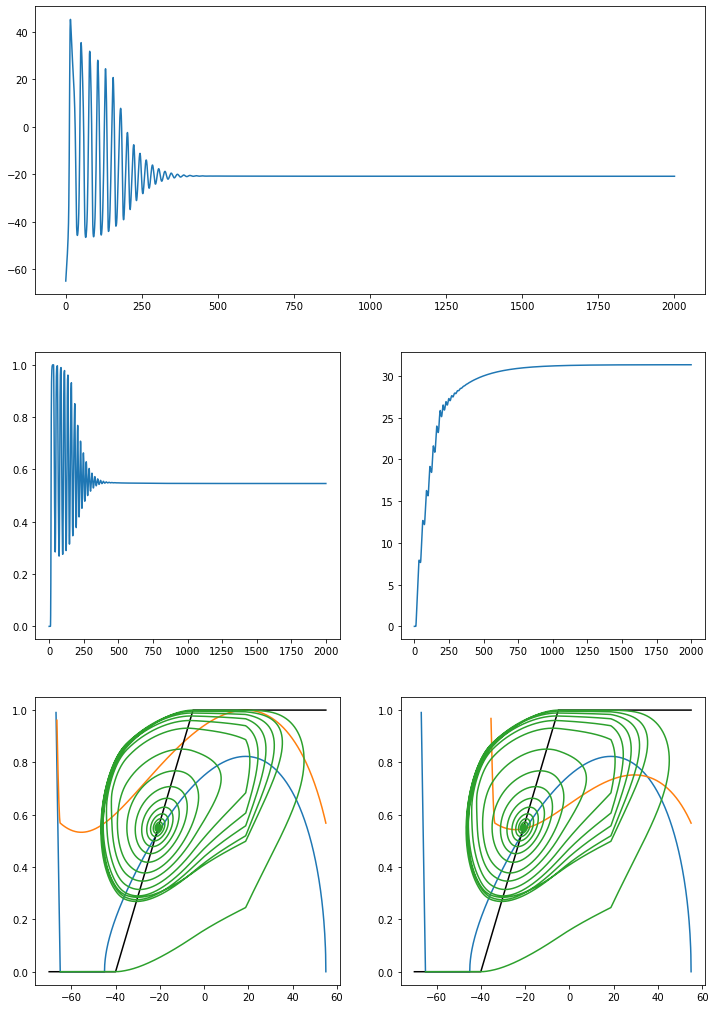

In [20]:
v0c   = safesqrt(vm, vectorize(P3)(vm,v0,v1,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+0. ,1)
v0cI0 = safesqrt(vm, vectorize(P3)(vm,v0,v1,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+I1 ,1)
zm    = amax(res[:,2])
v0cI1 = safesqrt(vm, vectorize(P3)(vm,v0+zm,v1+zm,v2)*vectorize(L1)(vm,v0+zm,a0,a1,0.)+I1 ,1)


f2 = figure(2, figsize=(12,18))
subplot2grid((3,2),(0,0),colspan=2)
plot(at,res[:,0])
subplot2grid((3,2),(1,0))
plot(at,res[:,1])
subplot2grid((3,2),(1,1))
plot(at,res[:,2])
subplot2grid((3,2),(2,0))
plot(v0c[:,0],v0c[:,1])
plot(v0cI0[:,0],v0cI0[:,1])
plot(vm,vectorize(L2)(vm,v4,0.,v5,1.,0.,0.),"k-")
plot(res[:200000,0],res[:200000,1])
subplot2grid((3,2),(2,1))
plot(v0c[:,0],v0c[:,1])
plot(v0cI1[:,0],v0cI1[:,1])
plot(vm,vectorize(L2)(vm,v4,0.,v5,1.,0.,0.),"k-")
plot(res[-200000:,0],res[-200000:,1])

show()